In [1]:
!pip install pyomo
!apt-get install -y -qq glpk-utils

In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyomo.environ import *
from pyomo.environ import Constraint

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Prediction**

In [4]:
# Load your DataFrame df
df= pd.read_csv('/content/drive/MyDrive/Capstone Project MMAI/Final Dataset For Model/indoor_parking.csv')


In [5]:
df

,Property Code,2022 Indoor Comp price,2023 Indoor Comp price,Total Units (2022Jul) (Indoor Parking),Occupied (2022Jul) (Indoor Parking),Percentage% (2022Jul) (Indoor Parking),New Lease (2022Jul) (Indoor Parking),Ending Lease (2022Jul) (Indoor Parking),Market Price (2022Jul) (Indoor Parking),Current Price (2022Jul) (Indoor Parking),...,Ending_Lease_Rate% (2023May) (Indoor Parking),Total Units (2023Jun) (Indoor Parking),Occupied (2023Jun) (Indoor Parking),Percentage% (2023Jun) (Indoor Parking),New Lease (2023Jun) (Indoor Parking),Ending Lease (2023Jun) (Indoor Parking),Market Price (2023Jun) (Indoor Parking),Current Price (2023Jun) (Indoor Parking),Lease_Turnover_Rate% (2023Jun) (Indoor Parking),Ending_Lease_Rate% (2023Jun) (Indoor Parking)
0,y31201,82.500000,83.750000,48.0,28.0,58.33,2.0,0.0,75.0,75.000000,...,156.25,48.0,27.0,56.25,0.0,23.0,75.0,78.181818,47.92,156.25
1,y31202,82.500000,83.750000,31.0,31.0,100.00,1.0,3.0,85.0,84.333333,...,274.19,31.0,31.0,100.00,0.0,3.0,85.0,110.000000,9.68,274.19
2,y31251,93.750000,125.000000,82.0,55.0,67.07,1.0,3.0,110.0,109.636364,...,134.15,82.0,58.0,70.73,0.0,31.0,110.0,110.000000,37.80,134.15
3,y31300,117.500000,121.250000,233.0,172.0,73.82,8.0,7.0,135.0,134.464286,...,56.49,239.0,164.0,68.62,1.0,90.0,135.0,136.049383,37.66,56.49
4,y31600,0.000000,0.000000,172.0,143.0,83.14,1.0,4.0,75.0,64.962121,...,42.61,176.0,141.0,80.11,5.0,57.0,75.0,67.840909,32.39,42.61
5,y31602,0.000000,96.666667,151.0,125.0,82.78,6.0,0.0,75.0,73.440000,...,51.02,147.0,138.0,93.88,0.0,12.0,75.0,73.595588,8.16,51.02
6,y40210,78.750000,77.500000,92.0,87.0,94.57,9.0,18.0,95.0,98.279070,...,102.15,93.0,87.0,93.55,1.0,34.0,95.0,113.376471,36.56,102.15
7,y40230,0.000000,71.666667,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,...,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.00,0.00
8,y40790,156.250000,156.250000,169.0,120.0,71.01,11.0,29.0,140.0,141.100917,...,81.40,172.0,115.0,66.86,4.0,88.0,140.0,140.943396,51.16,81.40
9,y40910,0.000000,38.666667,382.0,163.0,42.67,12.0,42.0,75.0,75.000000,...,19.63,382.0,195.0,51.05,1.0,217.0,75.0,75.000000,56.81,19.63


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 75 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Property Code                                    40 non-null     object 
 1   2022 Indoor Comp price                           40 non-null     float64
 2   2023 Indoor Comp price                           40 non-null     float64
 3   Total Units (2022Jul) (Indoor Parking)           40 non-null     float64
 4   Occupied (2022Jul) (Indoor Parking)              40 non-null     float64
 5   Percentage% (2022Jul) (Indoor Parking)           40 non-null     float64
 6   New Lease (2022Jul) (Indoor Parking)             40 non-null     float64
 7   Ending Lease (2022Jul) (Indoor Parking)          40 non-null     float64
 8   Market Price (2022Jul) (Indoor Parking)          40 non-null     float64
 9   Current Price (2022Jul) (Indoor Pa

In [7]:
# Define the month names
month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# Define the function to get the most recent month and year from the dataset
def get_recent_month_year(df):
    all_months = sorted([col.split(' ')[1][1:-1] for col in df.columns if "Percentage%" in col])
    recent_month = all_months[-1]
    recent_year = int(recent_month[:4])
    recent_month_name = recent_month[4:]
    recent_month_num = month_names.index(recent_month_name) + 1
    return recent_month_num, recent_year

# Get the recent month and year
recent_month, recent_year = get_recent_month_year(df)
recent_month_str = f'{recent_year}{month_names[recent_month - 1]}'
target_month = (recent_month % 12) + 1
target_year = recent_year if recent_month != 12 else recent_year + 1

In [8]:
# Get the previous month and year
previous_month = (recent_month - 2) % 12 + 1
previous_year = recent_year if previous_month != 12 else recent_year - 1

# Get the column name for the previous month's current prices
previous_month_column = f'Current Price ({previous_year}{month_names[previous_month - 1]}) (Indoor Parking)'

In [9]:
# Select relevant columns for the regression model
feature_columns = [col for col in df.columns if col not in ['Property Code', f'Percentage% ({recent_month_str}) (Indoor Parking)']]
target_column = f'Percentage% ({recent_month_str}) (Indoor Parking)'

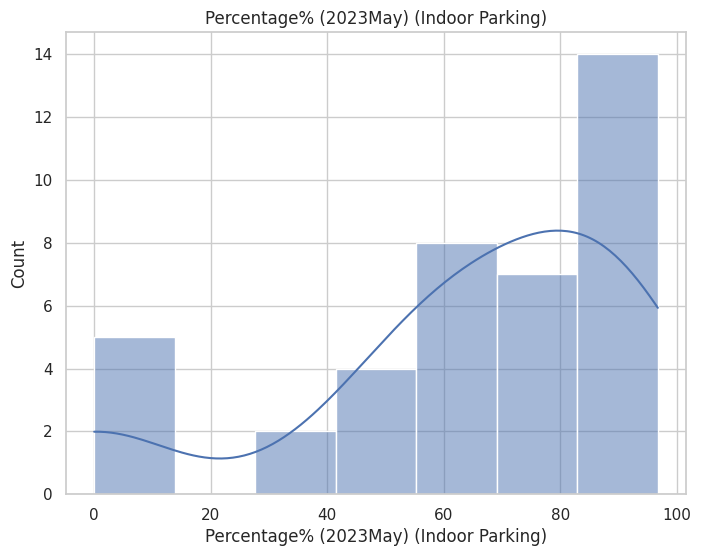

In [10]:
# Set the style of seaborn for our plots
sns.set(style="whitegrid")

# Plot the distribution of the target variable
plt.figure(figsize=(8, 6))
sns.histplot(df[target_column], kde=True)
plt.title(f'Percentage% ({recent_month_str}) (Indoor Parking)')
plt.show()

In [11]:
# Prepare the data
X = df[feature_columns]
y = df[target_column]

In [12]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Initialize and train the Random Forest model
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [14]:
# Get feature importances
importances = rf.feature_importances_
features_importances = sorted(zip(importances, X.columns), reverse=True)

In [15]:
# Print feature importances
for importance, name in features_importances:
    print(f"Feature: {name}, Importance: {importance}")

Feature: Percentage% (2023Jun) (Indoor Parking), Importance: 0.08599458834848496
Feature: Percentage% (2022Jul) (Indoor Parking), Importance: 0.07172123287603113
Feature: Percentage% (2023Apr) (Indoor Parking), Importance: 0.06926839679915572
Feature: Percentage% (2022Sep) (Indoor Parking), Importance: 0.05896303848931484
Feature: Percentage% (2022Oct) (Indoor Parking), Importance: 0.05841178116435465
Feature: Percentage% (2022Dec) (Indoor Parking), Importance: 0.04831822475029518
Feature: Percentage% (2022Aug) (Indoor Parking), Importance: 0.035352005955784284
Feature: Lease_Turnover_Rate% (2022Sep) (Indoor Parking), Importance: 0.024084439616084762
Feature: Market Price (2022Aug) (Indoor Parking), Importance: 0.023833668597330392
Feature: Lease_Turnover_Rate% (2022Oct) (Indoor Parking), Importance: 0.02323539593622468
Feature: Occupied (2023Apr) (Indoor Parking), Importance: 0.022889489372106126
Feature: Occupied (2023Jun) (Indoor Parking), Importance: 0.022800072997515176
Feature: T

In [16]:
# Select the most important features
important_features = [name for importance, name in features_importances if importance > 0.01]

# Prepare the data with only the most important features
X= df[important_features]


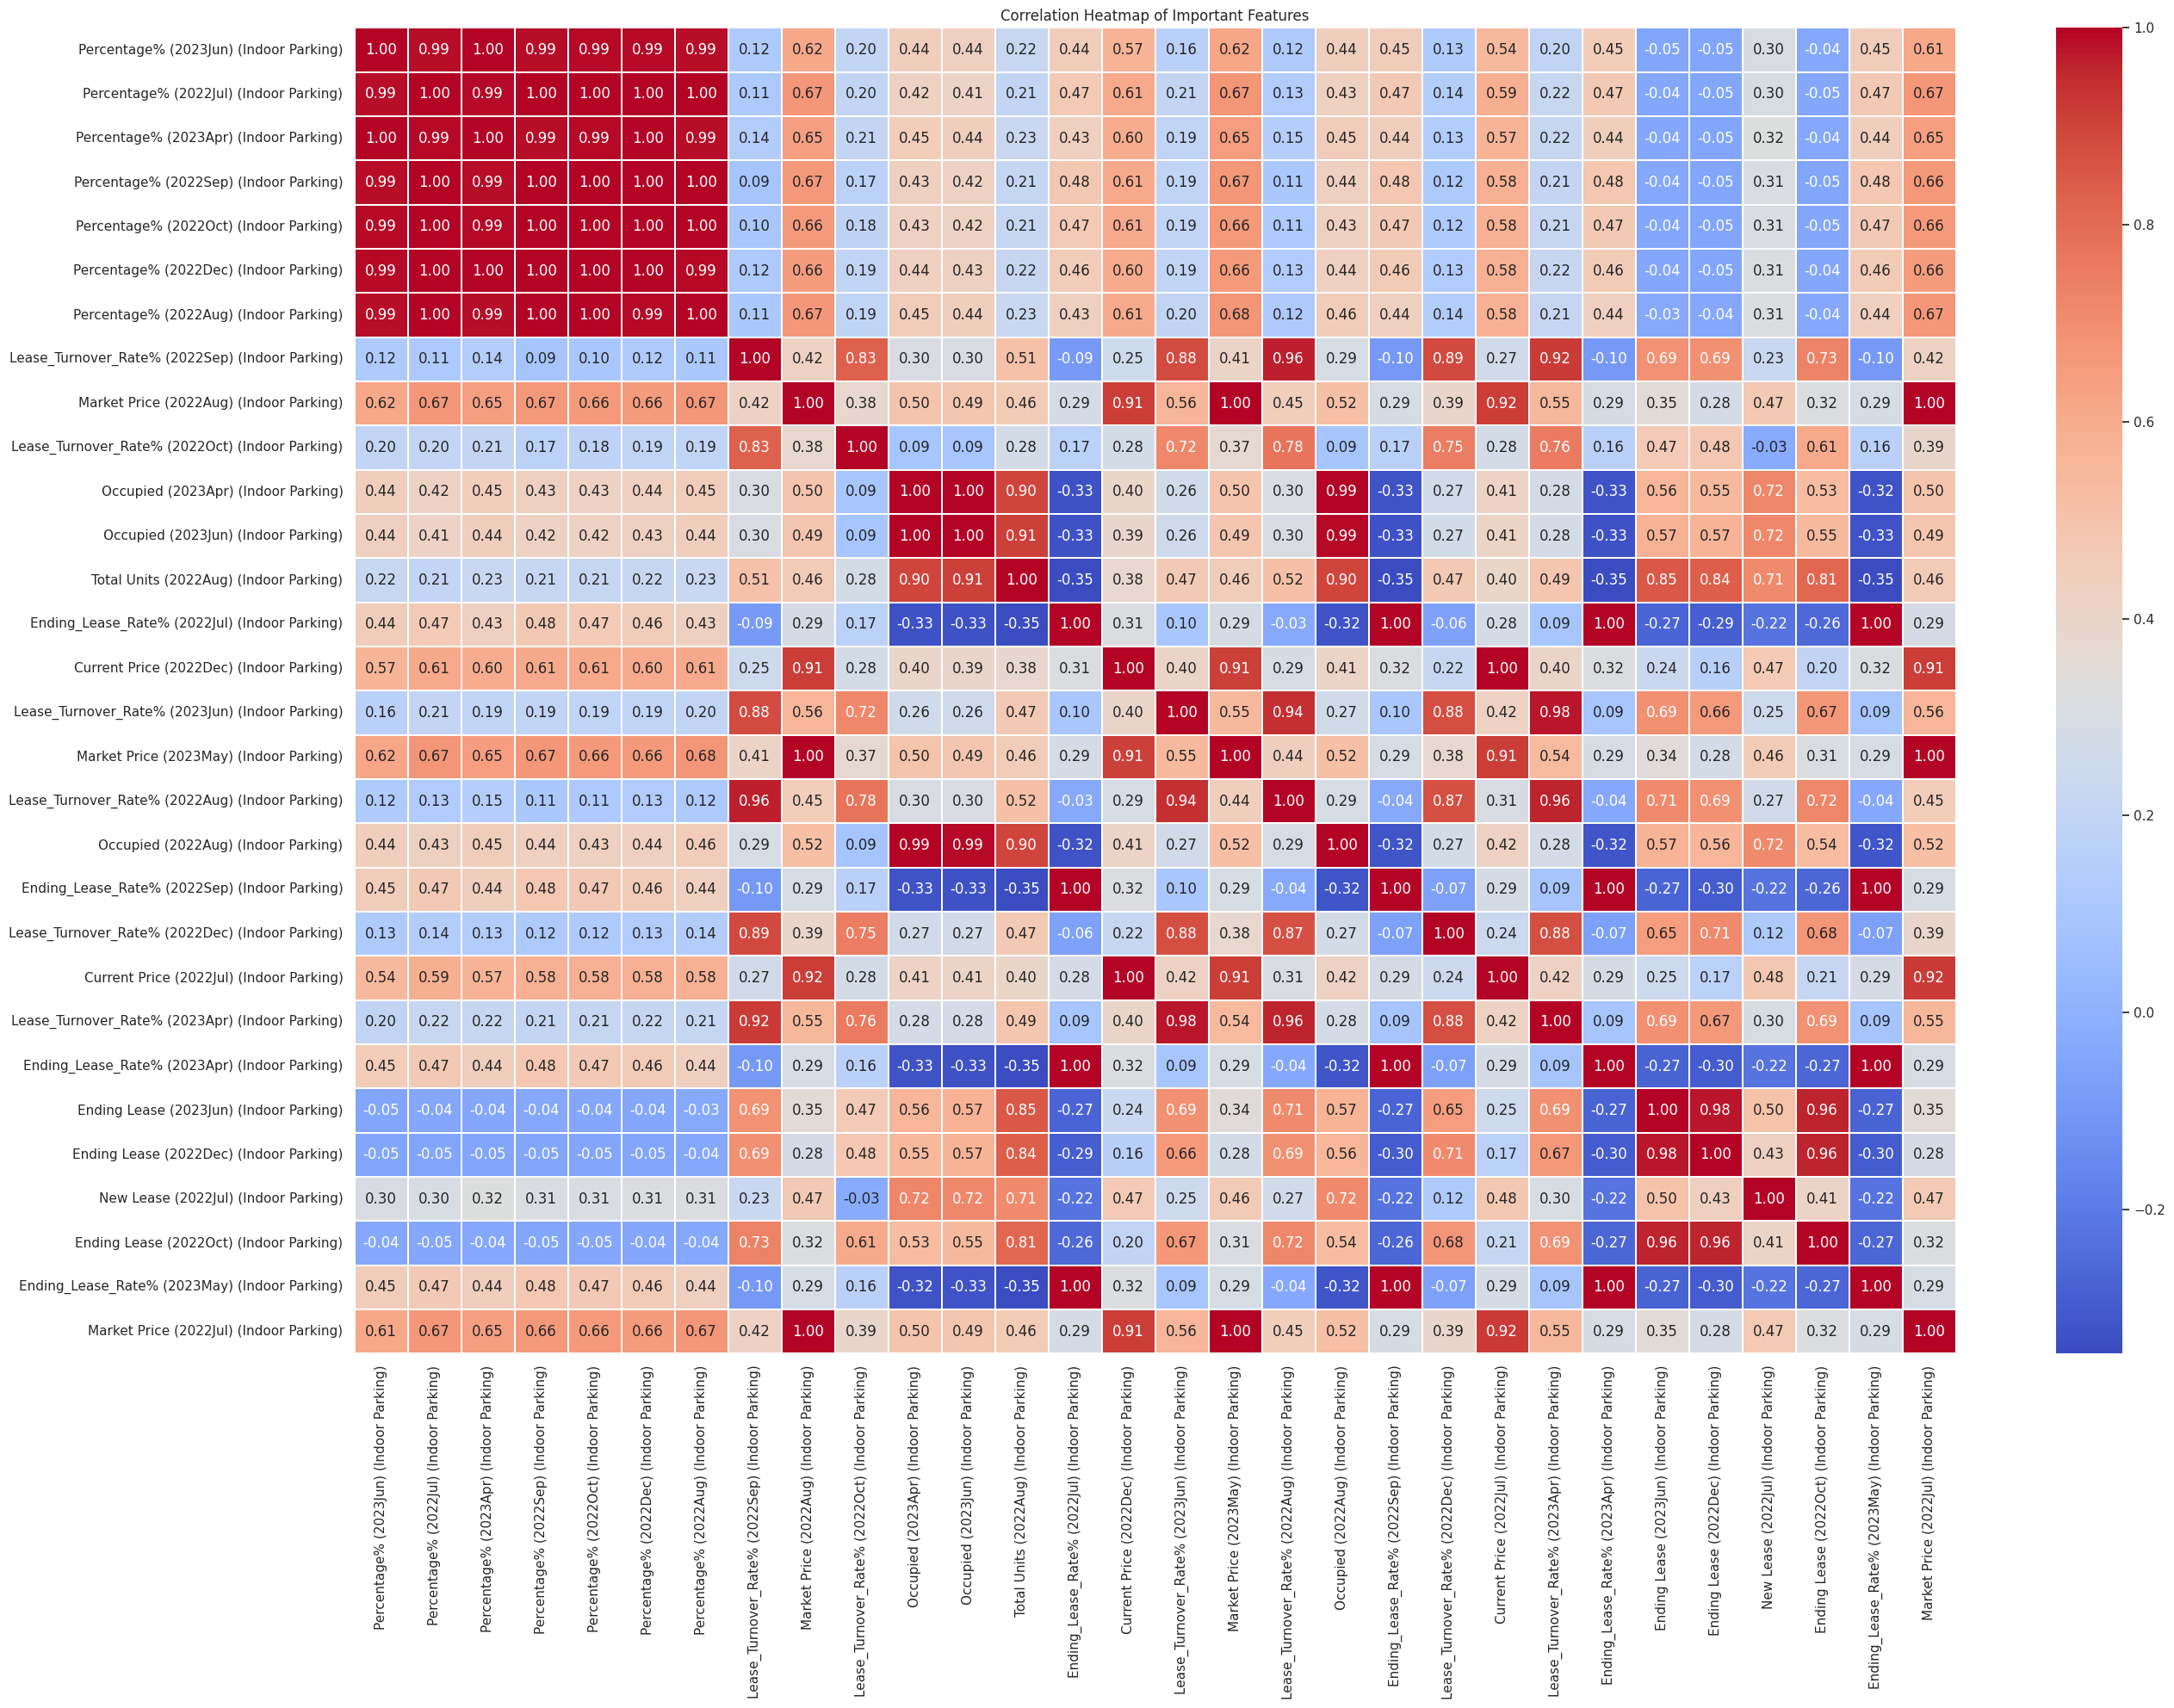

In [17]:
# Correlation heatmap of the important features
corr = df[important_features].corr()
plt.figure(figsize=(30, 20))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f",
            linewidths=0.1, linecolor='white', cbar=True)
plt.title('Correlation Heatmap of Important Features')
plt.show()

In [18]:
# Split the data into training and testing sets again
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# Initialize and train the Random Forest model again
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [20]:
# Predict the target variable for the test data
y_pred = rf.predict(X_test)

In [21]:
y_pred

array([90.7514, 89.7558, 78.7266, 60.7816, 82.739 , 85.9366, 82.837 ,
       89.9433])

In [22]:
# Bootstrap the residuals to calculate confidence intervals
n_iterations = 1000
alpha = 0.05  # 95% confidence interval
residuals_indoor = y_test - y_pred
lower_percentile = 100 * alpha / 2
upper_percentile = 100 * (1 - alpha / 2)
bootstrap_lower_updated = []
bootstrap_upper_updated = []

for i in range(n_iterations):
    bootstrap_residuals_updated = np.random.choice(residuals_indoor, size=len(residuals_indoor), replace=True)
    bootstrap_predictions_updated = y_pred + bootstrap_residuals_updated
    bootstrap_lower_updated.append(np.percentile(bootstrap_predictions_updated, lower_percentile))
    bootstrap_upper_updated.append(np.percentile(bootstrap_predictions_updated, upper_percentile))

lower_bound_updated = np.percentile(bootstrap_lower_updated, 50)
upper_bound_updated = np.percentile(bootstrap_upper_updated, 50)

lower_bound_updated, upper_bound_updated

(63.288452499999956, 90.7752775)

In [23]:
# Calculate and print the Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE:', rmse)

RMSE: 3.412195520665563


<ipython-input-24-b09e1adab908>:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4, color='red')


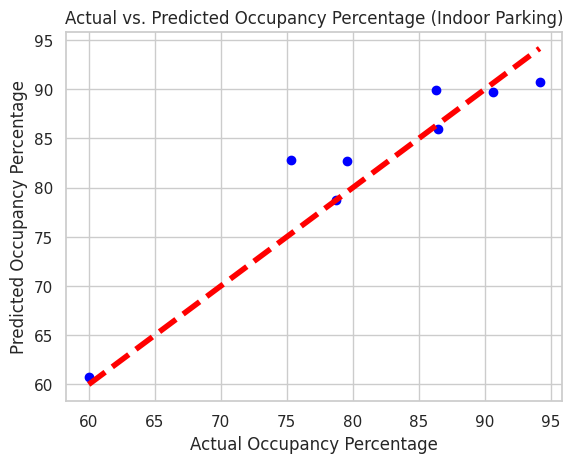

In [24]:
# Scatter plot of actual vs. predicted values
plt.scatter(y_test, y_pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4, color='red')
plt.xlabel('Actual Occupancy Percentage')
plt.ylabel('Predicted Occupancy Percentage')
plt.title('Actual vs. Predicted Occupancy Percentage (Indoor Parking)')
plt.show()


<ipython-input-25-d7276a4c2fc6>:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4, color='red')


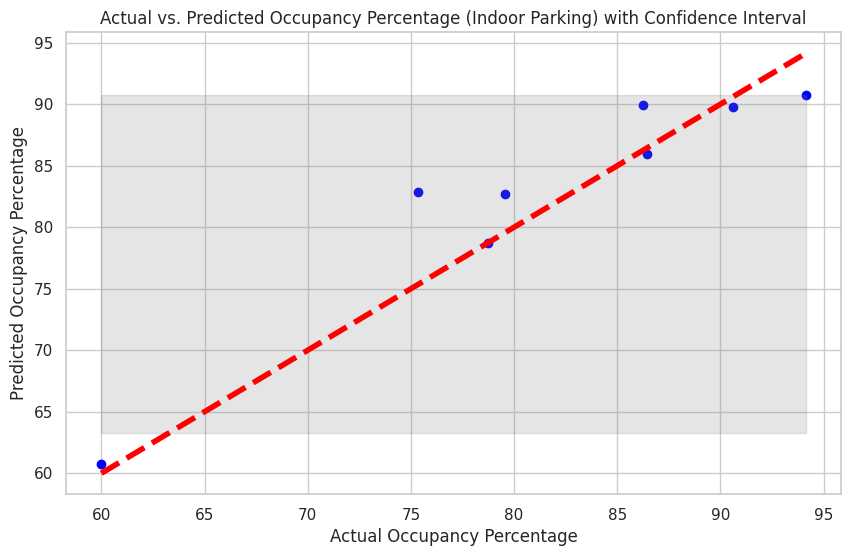

In [25]:
# Scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue')
plt.fill_between([y_test.min(), y_test.max()], lower_bound_updated, upper_bound_updated, color='grey', alpha=0.2)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4, color='red')
plt.xlabel('Actual Occupancy Percentage')
plt.ylabel('Predicted Occupancy Percentage')
plt.title('Actual vs. Predicted Occupancy Percentage (Indoor Parking) with Confidence Interval')
plt.show()

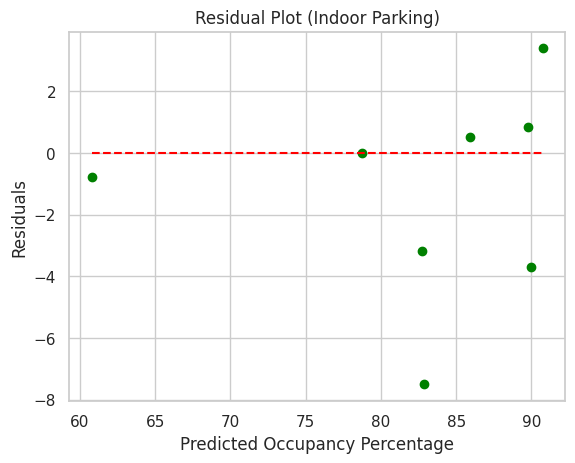

In [26]:
# Residual plot
plt.scatter(y_pred, residuals_indoor, color='green')
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='red', linestyles='dashed')
plt.xlabel('Predicted Occupancy Percentage')
plt.ylabel('Residuals')
plt.title('Residual Plot (Indoor Parking)')
plt.show()

# **OPTIMIZATION**

In [27]:
# Create a concrete model
model = ConcreteModel()

# Define the decision variables
model.price = Var(df.index, domain=NonNegativeReals)

In [28]:
# Define the objective function
def objective_rule(model):
    return sum(df.loc[i, target_column] * model.price[i] for i in df.index)
model.objective = Objective(rule=objective_rule, sense=maximize)

In [29]:
# Remove the existing constraints from the model
if hasattr(model, 'price_lower_limit_constraint'):
    model.del_component(model.price_lower_limit_constraint)
if hasattr(model, 'price_upper_limit_constraint'):
    model.del_component(model.price_upper_limit_constraint)

# Competitor price constraints for Indoor
for i in df.index:
    year = recent_month_str.split()[0]
    if year in ['2022', '2023']:  # This list can be extended for future years
        constraint_column = f"{year} Indoor Comp price"
        if constraint_column in df.columns:
            model.add_constraint(model.price[i] <= 1.05 * df.loc[i, constraint_column])

# Ask the user for the upper limit percentage (e.g. 1.1 for 110% of market price)
price_upper_limit = 1.1 #Can be changed

# Define the upper limit constraint for each property's price (must be <= specified percentage of market price)
market_price_column = f'Market Price ({recent_month_str}) (Indoor Parking)'
def price_upper_limit_constraint_rule(model, i):
    return model.price[i] <= price_upper_limit * df.loc[i, market_price_column]
model.price_upper_limit_constraint = Constraint(df.index, rule=price_upper_limit_constraint_rule)

# Ask the user for the lower limit percentage (e.g. 0.9 for 90% of market price)
price_lower_limit = 0.9 # Can be changed

# Define the lower limit constraint for each property's price (must be >= specified percentage of market price)
def price_lower_limit_constraint_rule(model, i):
    return model.price[i] >= price_lower_limit * df.loc[i, market_price_column]
model.price_lower_limit_constraint = Constraint(df.index, rule=price_lower_limit_constraint_rule)


In [30]:
# Solve the model
solver = SolverFactory('glpk')
solver.solve(model)

{'Problem': [{'Name': 'unknown', 'Lower bound': 313804.48, 'Upper bound': 313804.48, 'Number of objectives': 1, 'Number of constraints': 80, 'Number of variables': 40, 'Number of nonzeros': 80, 'Sense': 'maximize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 0, 'Number of created subproblems': 0}}, 'Error rc': 0, 'Time': 0.005396842956542969}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [31]:
# After solving the model
optimal_prices = [model.price[i].value for i in df.index]

print("Optimal prices: ", optimal_prices)


Optimal prices:  [82.5, 93.5, 121.0, 148.5, 82.5, 82.5, 104.5, 0.0, 154.0, 82.5, 137.5, 121.0, 121.0, 165.0, 60.5, 99.0, 137.5, 0.0, 143.0, 132.0, 154.0, 0.0, 132.0, 110.0, 148.5, 126.5, 93.5, 220.0, 0.0, 89.1, 66.0, 148.5, 148.5, 110.0, 110.0, 110.0, 0.0, 110.0, 198.0, 143.0]


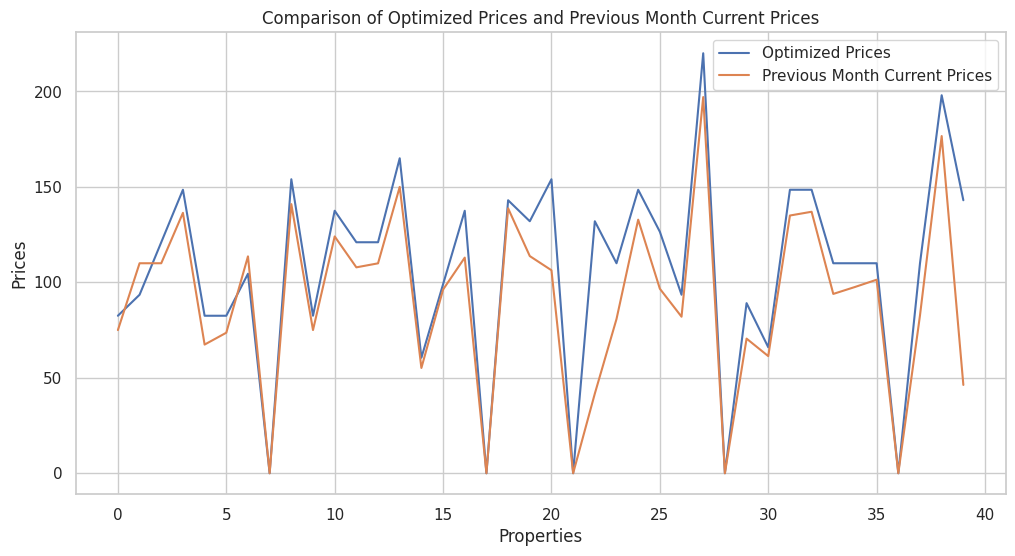

In [32]:
# Assuming you have a DataFrame `df` and the optimized prices are stored in a list `optimal_prices`
previous_month_current_prices = df[previous_month_column]

plt.figure(figsize=(12, 6))
plt.plot(df.index, optimal_prices, label='Optimized Prices')
plt.plot(df.index, previous_month_current_prices, label='Previous Month Current Prices')
plt.xlabel('Properties')
plt.ylabel('Prices')
plt.legend()
plt.title('Comparison of Optimized Prices and Previous Month Current Prices')
plt.show()

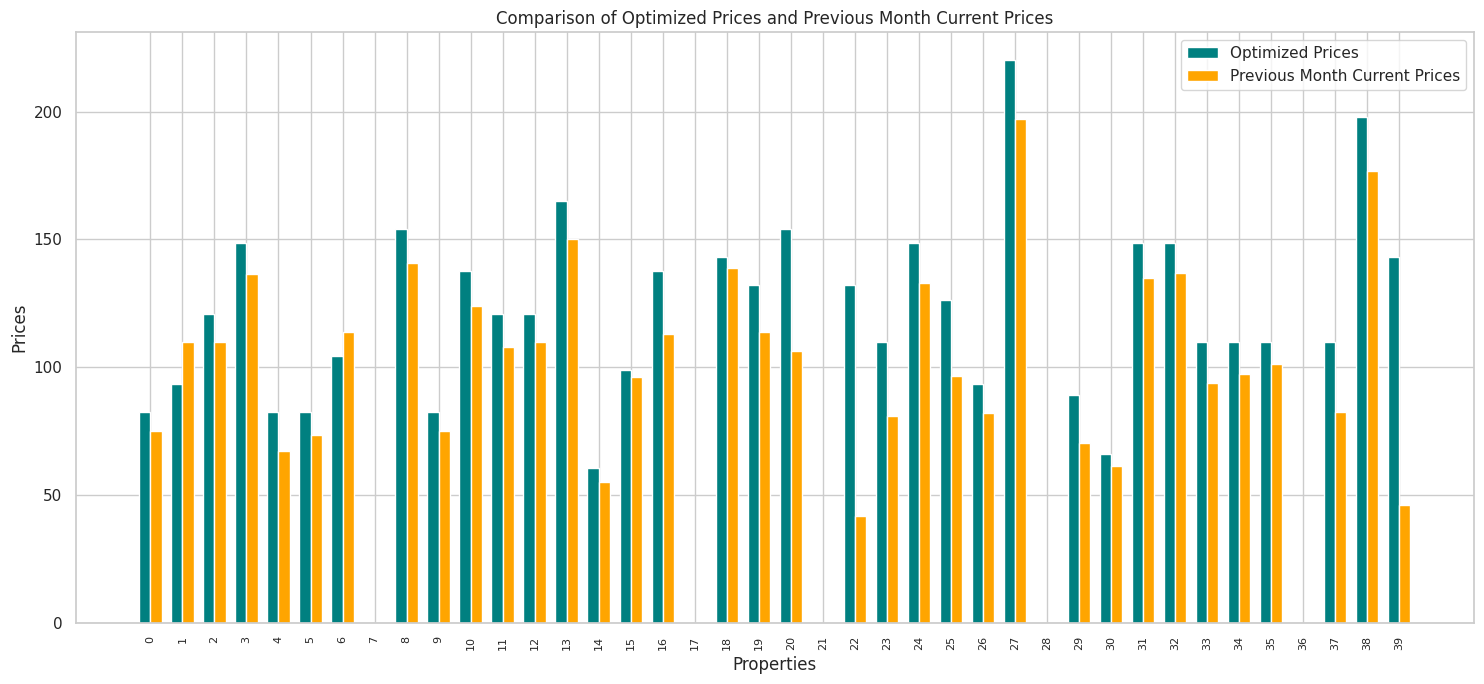

In [33]:
# Using side-by-side bar plots to compare the two distributions for each property
ind = np.arange(len(df.index))  # the x locations for the groups
width = 0.35  # the width of the bars

plt.figure(figsize=(15, 7))

# Plotting the bars
rects1 = plt.bar(ind - width/2, optimal_prices, width, label='Optimized Prices', color='teal')
rects2 = plt.bar(ind + width/2, previous_month_current_prices, width, label='Previous Month Current Prices', color='orange')

# Adding labels, title, and legend
plt.xlabel('Properties')
plt.ylabel('Prices')
plt.title('Comparison of Optimized Prices and Previous Month Current Prices')
plt.xticks(ind, df.index, rotation=90, fontsize=8)  # setting the x-ticks to be the property indices
plt.legend()

plt.tight_layout()
plt.show()


In [34]:
# Assuming you have a DataFrame `df` and the optimized prices are stored in a list `optimal_prices`
comparison_df = pd.DataFrame({
    'Property Code': df['Property Code'],
    'Optimized Prices': optimal_prices,
    'Previous Month Current Prices': previous_month_current_prices,
    'Difference': [optimal - previous for optimal, previous in zip(optimal_prices, previous_month_current_prices)]
})

# Display the comparison table
comparison_df


,Property Code,Optimized Prices,Previous Month Current Prices,Difference
0,y31201,82.5,75.000000,7.500000
1,y31202,93.5,110.000000,-16.500000
2,y31251,121.0,110.000000,11.000000
3,y31300,148.5,136.403509,12.096491
4,y31600,82.5,67.401575,15.098425
5,y31602,82.5,73.605839,8.894161
6,y40210,104.5,113.611765,-9.111765
7,y40230,0.0,0.000000,0.000000
8,y40790,154.0,140.970874,13.029126
9,y40910,82.5,75.000000,7.500000


In [35]:
# Calculate the current revenue for each property based on the current prices
current_revenue = sum(df["Current Price (2023Jun) (Indoor Parking)"][i] *
                      df["Total Units (2023Jun) (Indoor Parking)"][i] *
                      (df[target_column][i] * 0.01) for i in df.index)
# Calculate the optimized revenue using the provided optimal prices
optimized_revenue = sum(optimal_prices[i] *
                        df["Total Units (2023Jun) (Indoor Parking)"][i] *
                        (df[target_column][i] * 0.01) for i in range(len(optimal_prices)))

# Calculate the revenue difference based on the predicted occupancy
revenue_difference_predicted = optimized_revenue - current_revenue

print("Current Revenue:", current_revenue)
print("Optimized Revenue (Predicted):", optimized_revenue)
print("Total Revenue Difference (Predicted):", revenue_difference_predicted)

Current Revenue: 532149.110320309
Optimized Revenue (Predicted): 634184.1484000002
Total Revenue Difference (Predicted): 102035.03807969124


In [36]:
from google.colab import files

In [37]:
# Export the transformed training dataset to a CSV file
#comparison_df.to_csv('Indoor_Optimized_Prices.csv', index=False)
# Download the CSV file to your local computer
#files.download('Indoor_Optimized_Prices.csv')